<a href="https://colab.research.google.com/github/ahmedsalahj-1/gemini-ai-in-command-line/blob/main/DeepLearning12th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download the latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [01:48<00:00, 22.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [3]:

import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [4]:
import os
import PIL as Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adamax
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print('modules loaded')

modules loaded


In [5]:
train_data_dir = os.path.join(path, 'chest_xray', 'train')

if not os.path.isdir(train_data_dir):
    raise FileNotFoundError(f"{train_data_dir}")

filepaths = []
labels = []
folds = os.listdir(train_data_dir)


if len(folds) == 0:
    raise FileNotFoundError(f"لا توجد مجلدات داخل {train_data_dir}")

for f in folds:
    fpath=os.path.join(train_data_dir,f)
    fpaths=os.listdir(fpath)
    for file in fpaths:
        fale=os.path.join(fpath,file)
        filepaths.append(fale)
        labels.append(f)
fseries=pd.Series(filepaths,name='filepaths')
lseries=pd.Series(labels,name='labels')
df=pd.concat([fseries,lseries],axis=1)
df


,filepaths,labels
0,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
1,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
2,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
3,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
4,/root/.cache/kagglehub/datasets/paultimothymoo...,NORMAL
...,...,...
5211,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
5212,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
5213,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA
5214,/root/.cache/kagglehub/datasets/paultimothymoo...,PNEUMONIA


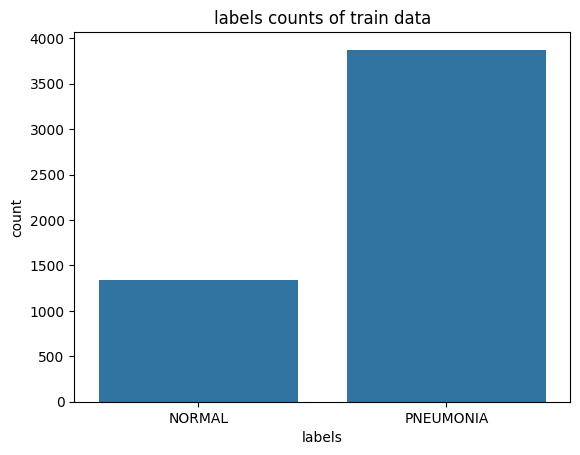

In [6]:
import seaborn as sns

sns.countplot(x='labels',data=df)
plt.title('labels counts of train data')
plt.show()

In [7]:
df['labels'].value_counts()


,count
labels,
PNEUMONIA,3875
NORMAL,1341


In [8]:
from sklearn.model_selection import train_test_split


train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

valid_df, test_df = train_test_split(dummy_df, test_size=0.5, shuffle=True, random_state=42)


print(len(train_df))
print(len(test_df))
print(len(valid_df))


4172
522
522


In [9]:
print(len(train_df))
print(len(test_df))
print(len(valid_df))

4172
522
522


In [10]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


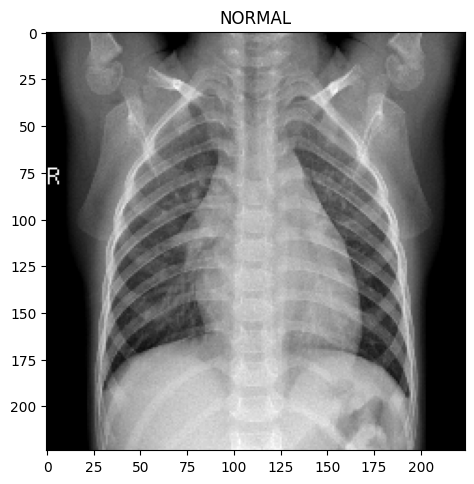

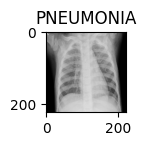

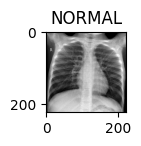

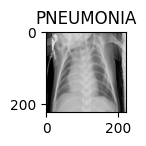

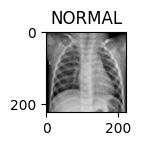

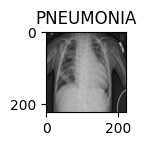

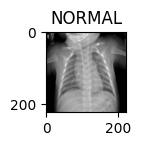

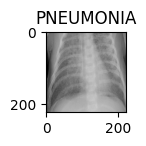

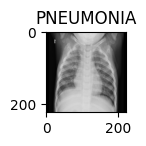

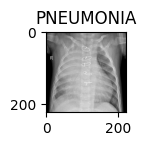

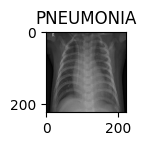

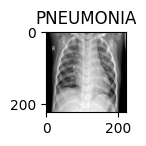

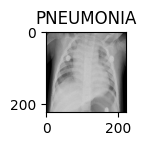

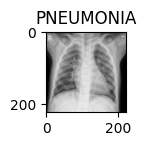

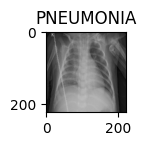

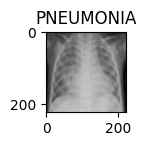

In [11]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (25,25))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255)
    index=np.argmax(labels[i])
    names=classes[index]
    plt.title(names)
    plt.show()

In [12]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,188,866 (77.01 MB)

 Trainable params: 164,482 (642.51 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [14]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

# تحميل النموذج الأساسي
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# جعل طبقات النموذج الأساسي غير قابلة للتدريب
for layer in base_model.layers:
    layer.trainable = False

# إضافة طبقات جديدة للنموذج
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # زيادة عدد الوحدات
x = Dropout(0.3)(x)                   # تقليل الـ Dropout
x = Dense(256, activation='relu')(x)  # زيادة عدد الوحدات
x = Dropout(0.3)(x)                   # تقليل الـ Dropout
output = Dense(2, activation='softmax')(x)

# إنشاء النموذج النهائي
model = Model(inputs=base_model.input, outputs=output)

# تجميع النموذج
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# عرض ملخص النموذج
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,418,882 (77.89 MB)

 Trainable params: 394,498 (1.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

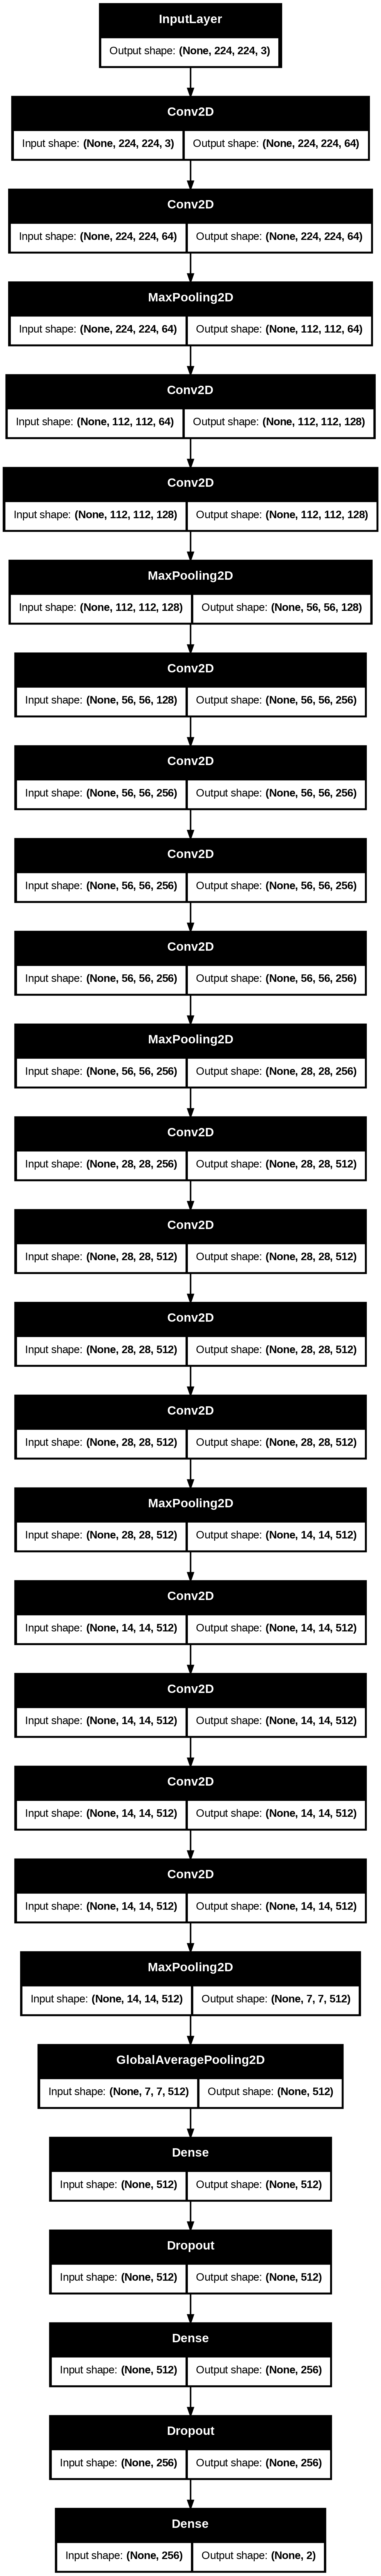

In [15]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=valid_gen,
    shuffle=False,
    validation_steps=None,
    callbacks=[early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


261/261 ━━━━━━━━━━━━━━━━━━━━ 85s 260ms/step - accuracy: 0.8590 - loss: 0.7382 - val_accuracy: 0.9559 - val_loss: 0.1006
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.9473 - loss: 0.1477 - val_accuracy: 0.9598 - val_loss: 0.1060
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 53s 203ms/step - accuracy: 0.9605 - loss: 0.1048 - val_accuracy: 0.9598 - val_loss: 0.0937
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 51s 197ms/step - accuracy: 0.9668 - loss: 0.0957 - val_accuracy: 0.9693 - val_loss: 0.0790
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 51s 193ms/step - accuracy: 0.9714 - loss: 0.0701 - val_accuracy: 0.9693 - val_loss: 0.0767
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 51s 195ms/step - accuracy: 0.9707 - loss: 0.0964 - val_accuracy: 0.9655 - val_loss: 0.0905
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 53s 203ms/step - accuracy: 0.9775 - loss: 0.0649 - val_accuracy: 0.9674 - val_loss: 0.0704
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 55s 211ms/step - accuracy: 0.9785 - loss: 0.0551 - val

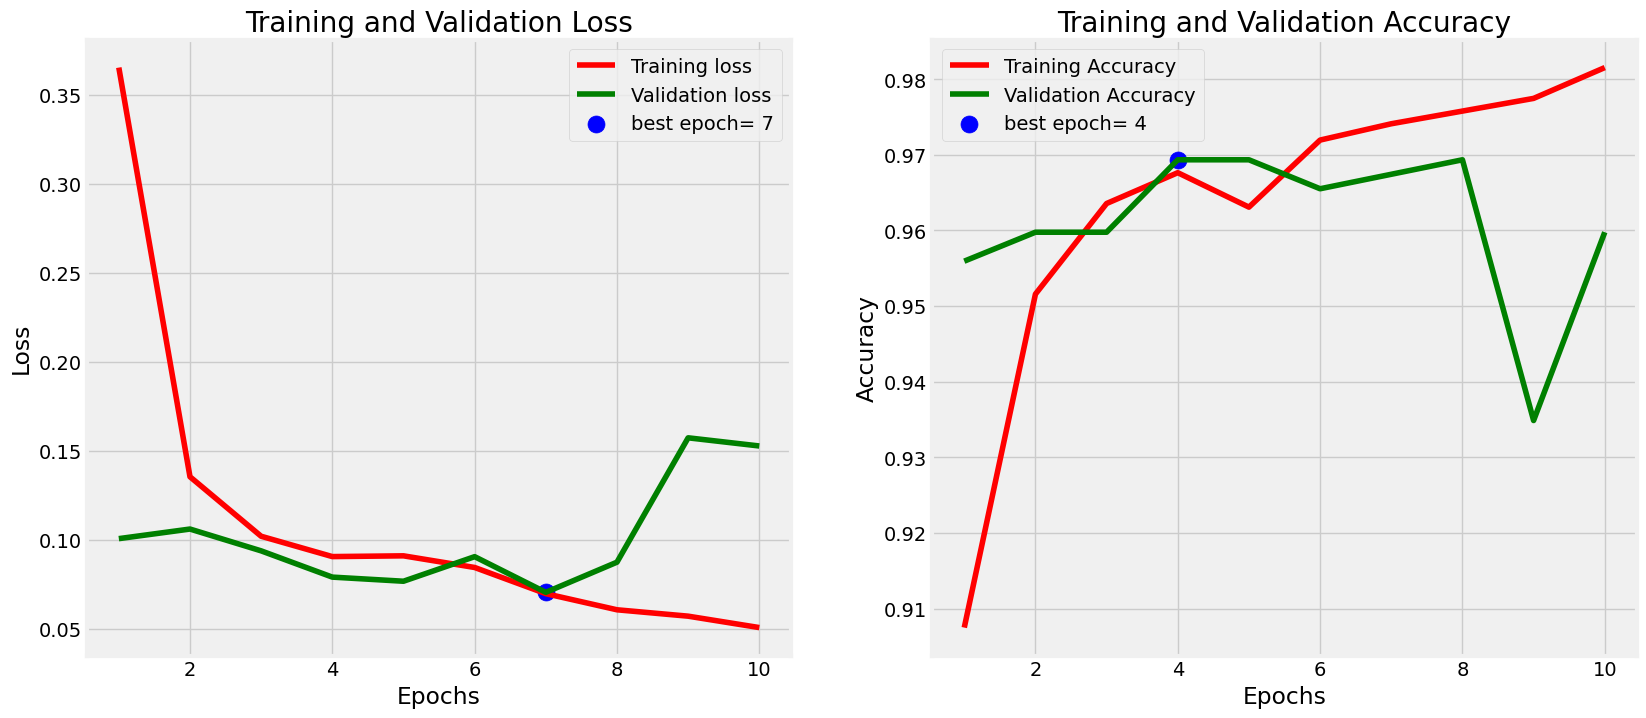

In [17]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [22]:
loss,accuracy=model.evaluate(test_gen)
print("loss : ",loss)
print("accuracy : ",accuracy)

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.9579 - loss: 0.0803
loss :  0.07138289511203766
accuracy :  0.969348669052124


In [43]:
# Training and validation accuracy
train_accuracy = history.history['accuracy'][-1]  # Last epoch
val_accuracy = history.history['val_accuracy'][-1]  # Last epoch

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

Training Accuracy: 98.15%
Validation Accuracy: 95.98%


In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
test_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Test Accuracy: 96.93%
Precision: 0.98
Recall: 0.98
F1 Score: 0.98


In [23]:
from sklearn.metrics import classification_report,confusion_matrix
y_pred=model.predict(test_gen)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,test_gen.classes))
print(confusion_matrix(y_pred,test_gen.classes))

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       135
           1       0.98      0.98      0.98       387

    accuracy                           0.97       522
   macro avg       0.96      0.96      0.96       522
weighted avg       0.97      0.97      0.97       522

[[126   9]
 [  7 380]]


In [40]:
from sklearn.metrics import confusion_matrix, classification_report

# Instead of using X_test, use test_gen to get predictions
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
# Instead of Y_test, use test_gen.classes to get true labels
confusion_mtx = confusion_matrix(test_gen.classes, y_pred_classes)
print("Confusion matrix:\n", confusion_mtx)

# Classification report
# Instead of Y_test, use test_gen.classes to get true labels
print(classification_report(test_gen.classes, y_pred_classes))

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step
Confusion matrix:
 [[126   7]
 [  9 380]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       133
           1       0.98      0.98      0.98       389

    accuracy                           0.97       522
   macro avg       0.96      0.96      0.96       522
weighted avg       0.97      0.97      0.97       522



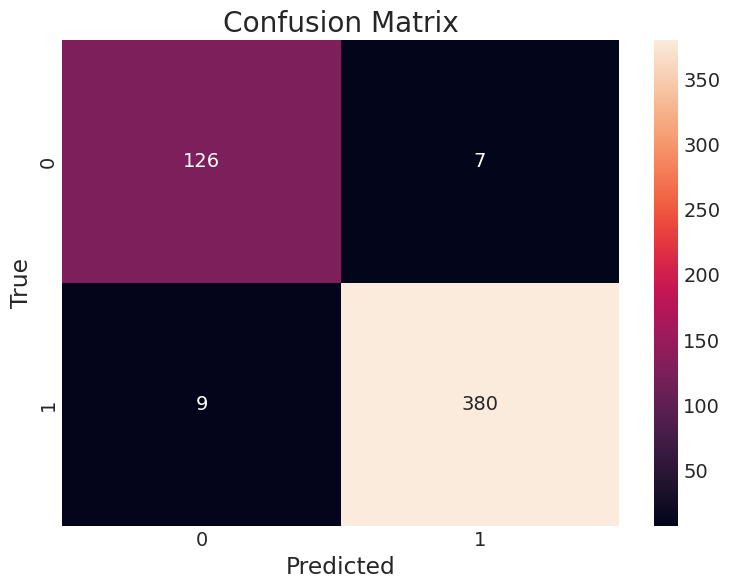

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step


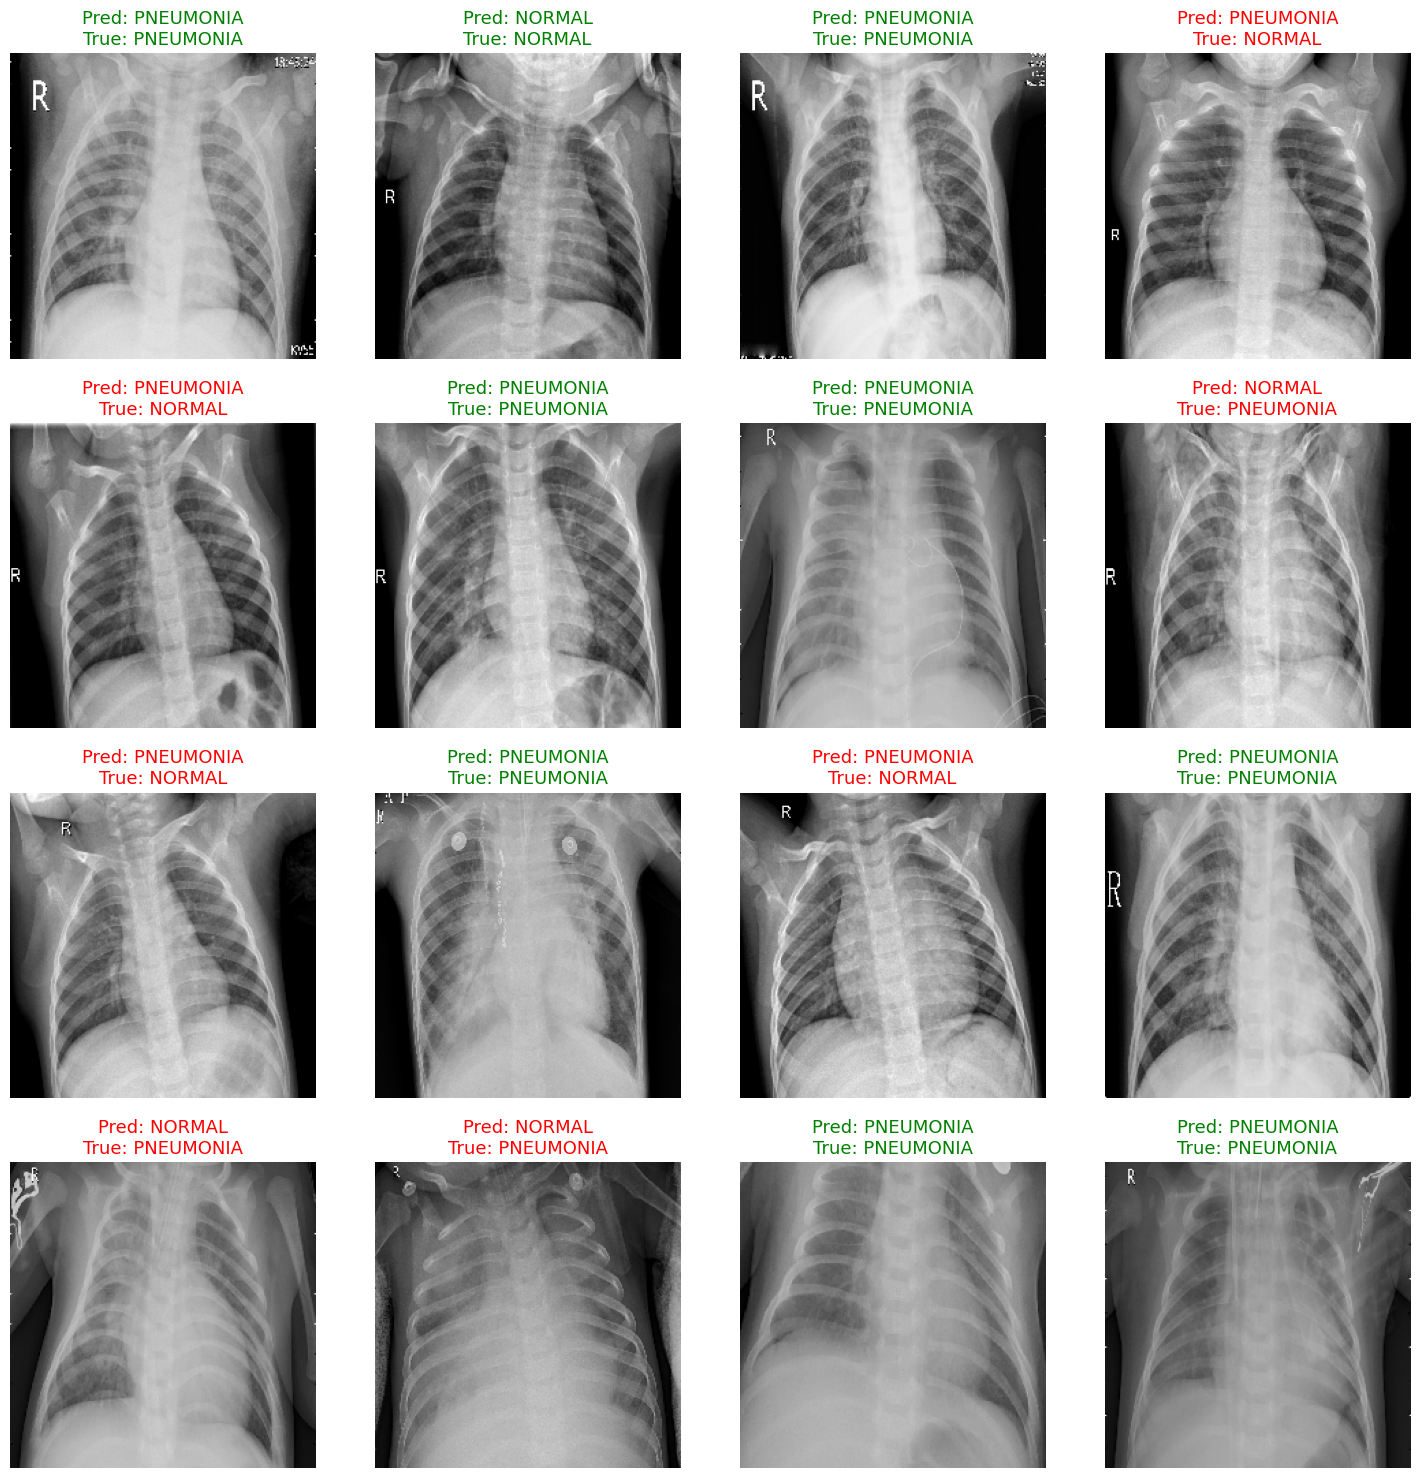

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Get the true labels for the test set
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Get a batch of images and labels from the test generator
images, labels = next(test_gen)

# Get predictions for the test set
y_pred = model.predict(test_gen)  # Get predictions from the model
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

num_images = 30
rows, cols = 4, 4

plt.figure(figsize=(15, 15))

for i in range(num_images):

    # Ensure the subplot index is within the valid range
    if i + 1 > rows * cols:
        break  # Stop the loop if we've reached the maximum number of subplots

    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i]/255)
    plt.axis('off')

    # Now y_pred is defined and can be used
    pred_label = class_labels[y_pred[i]]
    true_label = class_labels[np.argmax(labels[i])]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=13, color="green" if pred_label == true_label else "red")

plt.tight_layout()
plt.show()